# Sharp wave-ripple network model using cell models fitted to electrophysiological recordings

## Imports and basic declarations

In [1]:
#!/usr/bin/python
# -*- coding: utf8 -*-

from brian import *
import numpy as np
import matplotlib.pyplot as plt
import os
import gc
import sys
import random as pyrandom

# base directory of the project
SWBasePath = os.path.sep.join(os.path.abspath('__file__').split(os.path.sep)[:-2])
# add the 'scripts' directory to the path. now we can import the modules in there
sys.path.insert(0, os.path.sep.join([SWBasePath, 'scripts']))

from detect_oscillations import *
from plots import *

In [2]:
# filename of the asymmetric weight matrix
fIn = 'wmxR_asym.txt'

# define the directory where we save the figures
figures_folder = os.path.sep.join([SWBasePath, 'figures', 'jupyter_figures'])
if not os.path.exists(figures_folder):
    os.makedirs(figures_folder)

# size of the populations
NE = 4000
NI = 1000

# constant random seed
np.random.seed(123)
pyrandom.seed(123)

# sparseness
eps_pyr = 0.16
eps_bas = 0.4

### Pyramidal cell parameters

In [3]:
# parameters for pyr cells
pyr_params = np.genfromtxt('pyr_params.param')

z           = 1*nS
gL_Pyr      = pyr_params[0]     * uS
tauMem_Pyr  = pyr_params[1]     * ms
Cm_Pyr      = tauMem_Pyr * gL_Pyr
Vrest_Pyr   = pyr_params[2]     * mV
reset_Pyr   = pyr_params[3]     * mV
theta_Pyr   = pyr_params[4]     * mV
tref_Pyr    = pyr_params[5]     * ms

# Adaptation parameters for pyr cells
a_Pyr       = pyr_params[6] * nS              # nS    Subthreshold adaptation conductance
b_Pyr       = pyr_params[7] * nA              # nA    Spike-triggered adaptation
delta_T_Pyr = pyr_params[8] * mV              # Slope factor
tau_w_Pyr   = pyr_params[9] * ms              # Adaptation time constant
v_spike_Pyr = theta_Pyr + 10 * delta_T_Pyr

### Basket cell parameters

In [4]:
# parameters for bas cells
bas_params = np.genfromtxt('bas_params.param')

gL_Bas      = bas_params[0] * uS
tauMem_Bas  = bas_params[1] * ms
Cm_Bas      = tauMem_Bas * gL_Bas
Vrest_Bas   = bas_params[2] * mV
reset_Bas   = bas_params[3] * mV
theta_Bas   = bas_params[4] * mV
tref_Bas    = bas_params[5] * ms

# Adaptation parameters for pyr cells
a_Bas       = bas_params[6] * nS              # nS    Subthreshold adaptation conductance
b_Bas       = bas_params[7] * nA              # nA    Spike-triggered adaptation
delta_T_Bas = bas_params[8] * mV              # Slope factor
tau_w_Bas   = bas_params[9] * ms              # Adaptation time constant
v_spike_Bas = theta_Bas + 10 * delta_T_Bas

### Synaptic parameters

In [5]:
# synaptic weights
J_PyrInh = 0.04
J_BasExc = 32.
J_BasInh = 10.

# Synaptic reversal potentials
E_Exc = 0.0*mV
E_Inh = -70.0*mV

# Synaptic time constants
tauSyn_PyrExc = 10.0*ms
tauSyn_PyrInh = 3.0*ms * 1.1
tauSyn_BasExc = 3.0*ms
tauSyn_BasInh = 1.5*ms * 0.67

# Synaptic delays
delay_PyrExc = 3.0*ms
delay_PyrInh = 1.5*ms * 1.3
delay_BasExc = 3.0*ms
delay_BasInh = 1.5*ms * 0.6

# input parameters
p_rate_mf = 25. * Hz
J_PyrMF = 18.

In [6]:
print 'J_PyrInh:', J_PyrInh
print 'J_BasExc:', J_BasExc
print 'J_BasInh:', J_BasInh

J_PyrInh: 0.04
J_BasExc: 32.0
J_BasInh: 10.0


### Cell model definitions

In [7]:
eqs_adexp = '''
dvm/dt = (-gL_Pyr*(vm-Vrest_Pyr) + gL_Pyr*delta_T_Pyr*exp((vm- theta_Pyr)/delta_T_Pyr)-w - (g_ampa*z*(vm-E_Exc) + g_gaba*z*(vm-E_Inh)))/Cm_Pyr : volt
dw/dt = (a_Pyr*(vm- Vrest_Pyr )-w)/tau_w_Pyr : amp
dg_ampa/dt = -g_ampa/tauSyn_PyrExc : 1
dg_gaba/dt = -g_gaba/tauSyn_PyrInh : 1
'''

eqs_bas = '''
dvm/dt = (-gL_Bas*(vm-Vrest_Bas) + gL_Bas*delta_T_Bas*exp((vm- theta_Bas)/delta_T_Bas)-w - (g_ampa*z*(vm-E_Exc) + g_gaba*z*(vm-E_Inh)))/Cm_Bas : volt
dw/dt = (a_Bas*(vm- Vrest_Bas )-w)/tau_w_Bas : amp
dg_ampa/dt = -g_ampa/tauSyn_BasExc : 1
dg_gaba/dt = -g_gaba/tauSyn_BasInh : 1
'''

def myresetfunc(P, spikes):
    P.vm[spikes] = reset_Pyr    # reset voltage
    P.w[spikes] += b_Pyr        # low pass filter of spikes (adaptation mechanism)


def basresetfunc(P, spikes):
    P.vm[spikes] = reset_Bas
    P.w[spikes] += b_Bas

SCR_Pyr = SimpleCustomRefractoriness(myresetfunc,  tref_Pyr, state='vm')
SCR_Bas = SimpleCustomRefractoriness(basresetfunc, tref_Bas, state='vm')

## Creating and initializing populations

In [8]:
PE = NeuronGroup(NE, model=eqs_adexp, threshold=v_spike_Pyr, reset=SCR_Pyr)
PI = NeuronGroup(NI, model=eqs_bas,   threshold=v_spike_Bas, reset=SCR_Bas)

PE.vm = Vrest_Pyr
PE.g_ampa = 0
PE.g_gaba = 0

PI.vm  = Vrest_Bas
PI.g_ampa = 0
PI.g_gaba = 0

MF = PoissonGroup(NE, p_rate_mf)

## Connecting the network

In [9]:
print 'Connecting the network'

Cext = IdentityConnection(MF, PE, 'g_ampa', weight=J_PyrMF)

Cee = Connection(PE, PE, 'g_ampa', delay=delay_PyrExc)

fName = os.path.join(SWBasePath, 'files', fIn)
Wee = np.genfromtxt(fName) * 1.e9 * 4.0
np.fill_diagonal(Wee, 0)
gc.collect()

Cee.connect(PE, PE, Wee)

Cei = Connection(PE, PI, 'g_ampa', weight=J_BasExc, sparseness=eps_pyr, delay=delay_BasExc)
Cie = Connection(PI, PE, 'g_gaba', weight=J_PyrInh, sparseness=eps_bas, delay=delay_PyrInh)
Cii = Connection(PI, PI, 'g_gaba', weight=J_BasInh, sparseness=eps_bas, delay=delay_BasInh)

print 'Connections done'

Connecting the network
Connections done


## Defining the monitors

In [10]:
# # Monitors
sme = SpikeMonitor(PE)
smi = SpikeMonitor(PI)
popre = PopulationRateMonitor(PE)
popri = PopulationRateMonitor(PI)
#selection = np.arange(0, 4000, 100) # subset of neurons for recoring variables
#msMe = MultiStateMonitor(PE, vars=['vm', 'w', 'g_ampa', 'g_gaba'], record=selection.tolist())  # comment this out later (takes a lot of memory!)

## Running the simulation

In [11]:
run(10000*ms, report='text')

13% complete, 10s elapsed, approximately 1m 4s remaining.
26% complete, 20s elapsed, approximately 54s remaining.
40% complete, 30s elapsed, approximately 44s remaining.
54% complete, 40s elapsed, approximately 33s remaining.
68% complete, 50s elapsed, approximately 23s remaining.
82% complete, 1m 0s elapsed, approximately 12s remaining.
96% complete, 1m 10s elapsed, approximately 2s remaining.
100% complete, 1m 12s elapsed, approximately 0s remaining.


In [12]:
# total number or spikes per population
print sme.nspikes
print smi.nspikes

76583
1099180


## Analysis, raster, ISI

In [13]:
if sme.nspikes > 0 and smi.nspikes > 0:
    spikeTimesE        = np.array(sme.spikes)[:,1]*1000.
    spikingNeuronsE    = np.array(sme.spikes)[:,0]
    poprE              = popre.rate_.reshape(-1, 10).mean(axis=1)
    ISIs               = np.hstack([np.diff(spikes_i*1000) for i, spikes_i in sme.spiketimes.items()])
    ISIhist, bin_edges = np.histogram(ISIs, bins=20, range=(0,1000))

    spikeTimesI        = np.array(smi.spikes)[:,1]*1000.
    spikingNeuronsI    = np.array(smi.spikes)[:,0]
    poprI              = popri.rate_.reshape(-1, 10).mean(axis=1)
    
    
    # calling detect_oscillation functions:
    avgReplayInterval = replay(ISIhist[3:16])  # bins from 150 to 850 (range of interest)

    meanEr, rEAC, maxEAC, tMaxEAC, maxEACR, tMaxEACR, fE, PxxE, avgRippleFE, ripplePE = ripple(poprE, 1000)
    avgGammaFE, gammaPE = gamma(fE, PxxE)
    meanIr, rIAC, maxIAC, tMaxIAC, maxIACR, tMaxIACR, fI, PxxI, avgRippleFI, ripplePI = ripple(poprI, 1000)
    avgGammaFI, gammaPI = gamma(fI, PxxI)

    # Print out some info
    print 'Mean excitatory rate: ', meanEr
    print 'Maximum exc. autocorrelation:', maxEAC, 'at', tMaxEAC, '[ms]'
    print 'Maximum exc. AC in ripple range:', maxEACR, 'at', tMaxEACR, '[ms]'
    print 'Mean inhibitory rate: ', meanIr
    print 'Maximum inh. autocorrelation:', maxIAC, 'at', tMaxIAC, '[ms]'
    print 'Maximum inh. AC in ripple range:', maxIACR, 'at', tMaxIACR, '[ms]'
    print ''
    print 'Average exc. ripple freq:', avgRippleFE
    print 'Exc. ripple power:', ripplePE
    print 'Average exc. gamma freq:', avgGammaFE
    print 'Exc. gamma power:', gammaPE
    print 'Average inh. ripple freq:', avgRippleFI
    print 'Inh. ripple power:', ripplePI
    print 'Average inh. gamma freq:', avgGammaFI
    print 'Inh. gamma power:', gammaPI
    print "--------------------------------------------------"
    
else:
    print 'No activity!'

Replay, avg. replay interval: 475.035715786 [ms]
Mean excitatory rate:  1.914575
Maximum exc. autocorrelation: 0.691837001595 at 12 [ms]
Maximum exc. AC in ripple range: 0.667652086929 at 6 [ms]
Mean inhibitory rate:  109.918
Maximum inh. autocorrelation: 0.841036610854 at 6 [ms]
Maximum inh. AC in ripple range: 0.841036610854 at 6 [ms]

Average exc. ripple freq: 167.96875
Exc. ripple power: 65.2564070492
Average exc. gamma freq: nan
Exc. gamma power: 10.7429618175
Average inh. ripple freq: 169.921875
Inh. ripple power: 55.9800302326
Average inh. gamma freq: nan
Inh. gamma power: 1.27111433514
--------------------------------------------------


## Plots

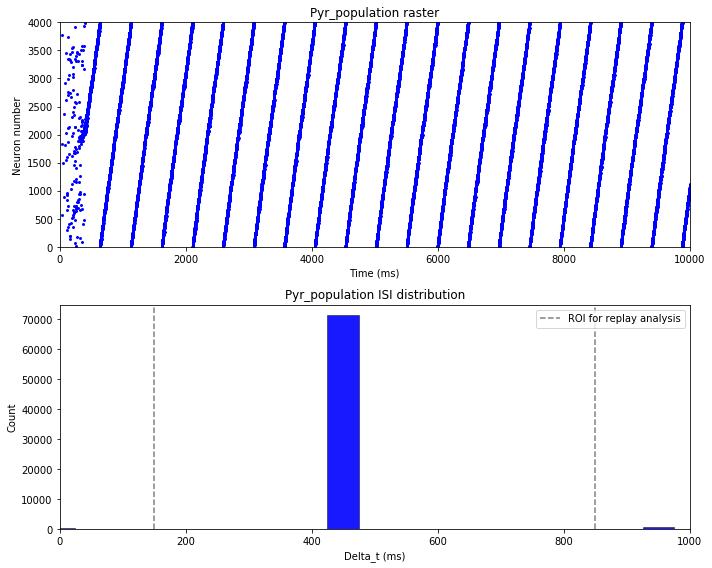

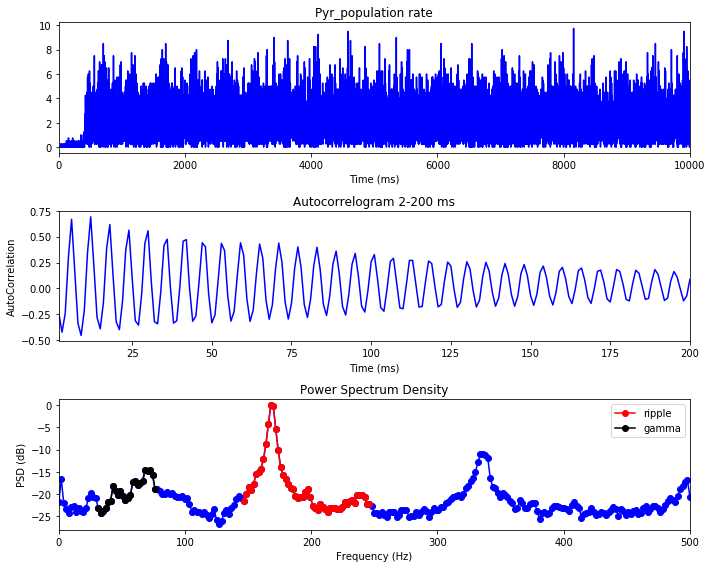

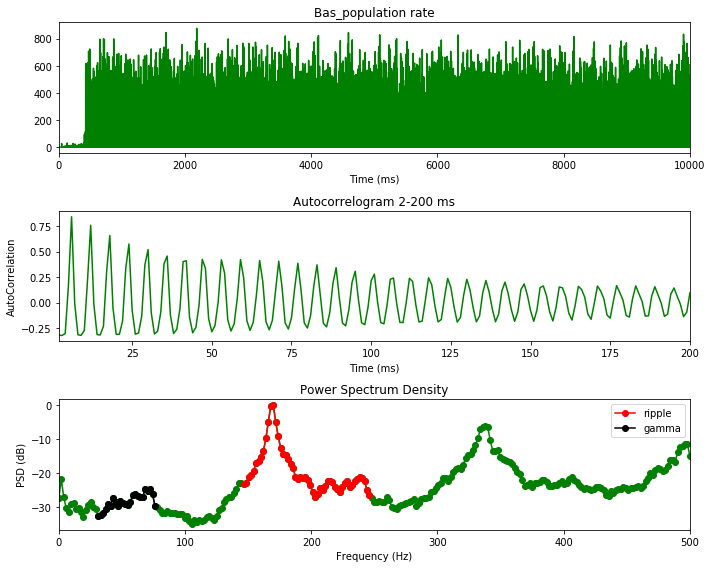

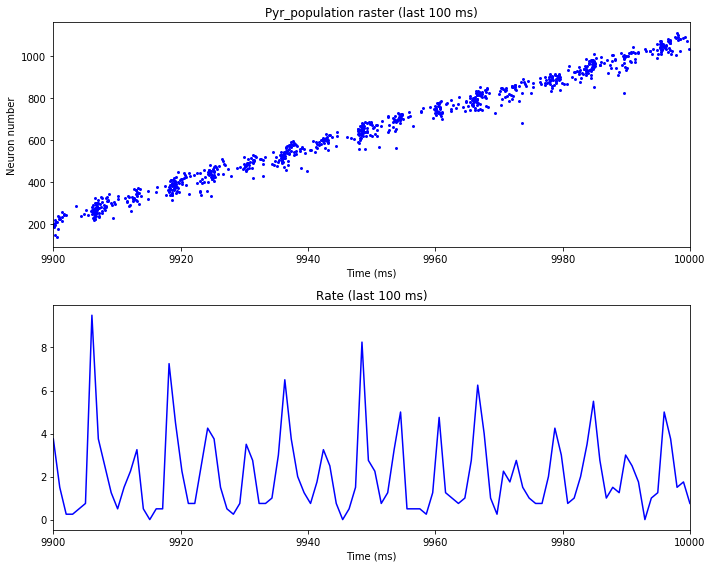

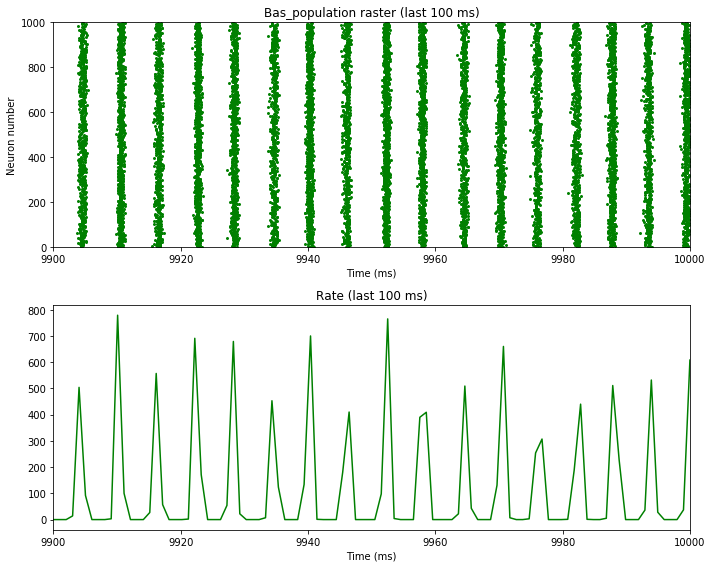

In [18]:
%matplotlib inline
if sme.nspikes > 0 and smi.nspikes > 0:
    plot_raster_ISI(spikeTimesE, spikingNeuronsE, [ISIhist, bin_edges], 'blue', multiplier_=1)
    plot_PSD(poprE, rEAC, fE, PxxE, "Pyr_population", 'b-', multiplier_=1)
    plot_PSD(poprI, rIAC, fI, PxxI, "Bas_population", 'g-', multiplier_=1)

    ymin, ymax = plot_zoomed(spikeTimesE, spikingNeuronsE, poprE, "Pyr_population", "blue", multiplier_=1)
    plot_zoomed(spikeTimesI, spikingNeuronsI, poprI, "Bas_population", "green", multiplier_=1, Pyr_pop=False)
    #subset = select_subset(selection, ymin, ymax)
    #plot_detailed(msMe, subset, multiplier_=1)
    #plot_adaptation(msMe, selection, multiplier_=1)